## Sparse solutions for temporal BRDF characterisation

P. Lewis, UCL/NCEO

## Introduction
We have in increasing number (15+) years of global high quality observations of spectral directional reflectance from Earth Observation (EO) measurements at 'coarse' spatial resolution (250m to 1 km) that provide the raw data for inference of land surface state. In many such datasets, increased temporal sampling is provided by using wide field of view sensors in Low Earth Orbit (LEO). This gives rise to what are termed 'BRDF effects' in the data that appear as high frequency variations in the temporal signal and can greatly complicate interpretation (**amazon refs**). Whilst band ratios can somewhat mitigate such effects, residual 'BRDF noise' will appear in such data. We have had a range of simple and practical 'semi empirical' models available for some decades to aid angular normalisation and integration of the signal, the 'kernel-driven' linear BRDF models such as those of Roujean et al. (1992) and Wanner et al. (1995) that have permitted the development of global BRDF/albedo products such as MCD43 etc.

The aim of these models is to attempt to *describe* the angular and temporal variation in BRDF 


Blaa blaa 


compressive sensing approach using Lasso L1 norm




In [1]:
import glob
import numpy as np
import pylab as plt
import gdal
import os
from kernels import Kernels
try:
   import cPickle as pickle
except:
   import pickle

coreKeys = ['isotropic','ross','li','system:time_start']
bandkeys = ['sur_refl_b%02d'%i for i in xrange(1,8)]


data = pickle.load( open( "Angola/data.core.p", "rb" ) )
for i in xrange(7):
    data[i] = pickle.load( open( "Angola/data.band%02d.p"%(i+1), "rb" ) )

60 40
(1, 267)


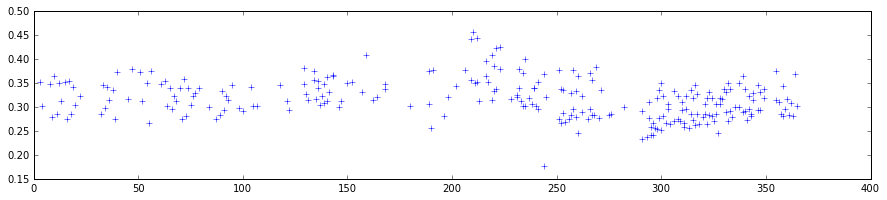

In [3]:
%matplotlib inline
from scipy.fftpack import dct, idct
from scipy.sparse import coo_matrix

plt.figure(figsize=(15,3))
px = 60
py = 40
print px,py
mask = data[1]>0
m = mask[px,py]
# days since epoch
t = data['system:time_start'][px,py][m] * 365 
t -= t[0]

start = 365*2. # select a year of data
ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
t = t[ww] - start
nbands = 7

whichBands = [1]
refl = np.array([data[i][px,py][m][ww] for i in whichBands])
print refl.shape
R = data['ross'][px,py][m][ww]
L = data['li'][px,py][m][ww]
I = data['isotropic'][px,py][m][ww]
tt = t/365.25

#plt.plot(t,(refl[1]-refl[0])/(refl[1]+refl[0]),'+')
for i,b in enumerate(whichBands):
    plt.plot(t,refl[i],'+')


In [193]:
def getAb(N,fn=np.cos,tt=None,phi=None,reweight=False,overwriteK=False,K=np.array([I,R,L]),refl=refl):
    
    
    nk = K.shape[0]
    ns = K.shape[1]
    if refl is not None:
        if refl.ndim == 1:
            nbands=1
        else:
            assert ns == refl.shape[-1] 
            nbands = refl.shape[0]
    else:
        nbands = 0

    A = np.matrix(np.zeros((N*nk,N*nk)))
    b = np.matrix(np.zeros((N*nk,nbands)))
    Ks = []
    if not reweight:
        for i in xrange(N):
            Ki = np.matrix(K*(fn(i,tt=tt,phi=phi)))
            Ks.append(Ki)
            if refl is not None:
                Ri = np.matrix(refl)
                for band in xrange(nbands):
                    b[i*3:(i+1)*3,band] = (Ki * Ri.T)[:,band]

    for i in xrange(N):
        Ki = np.matrix(K*(fn(i,tt=tt,phi=phi)))
        if reweight:
            # only do the diagonal
            j = i
            A[i*nk:(i+1)*nk,j*nk:(j+1)*nk,] = Ki * Ki.T
        else:
            for j in xrange(N):
                Kj = np.matrix(K*(fn(j,tt=tt,phi=phi)))
                A[i*nk:(i+1)*nk,j*nk:(j+1)*nk,] = Ki * Kj.T
    if reweight: 
        sizes = np.diagonal(A)
        weights = np.sqrt(sizes/sizes[0])*0 + 1
        #for i in xrange(1,len(weights)):
        #    weights[i] /= 10.
        if overwriteK:
            K_ = K
        else:
            K_ = K.copy()
        for i in xrange(nk):
            K_[i] /= weights[i]
        return getAb(N,fn=fn,K=K_,tt=tt,phi=phi,refl=refl,\
                    overwriteK=overwriteK,reweight=False)
                    
    return A/(float(N*N)),b/(float(N*N)),np.array(Ks)

We first fit the data assuming a constant set of parameters (constant in time).

/Users/plewis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:94: UserWarning: you are warned!


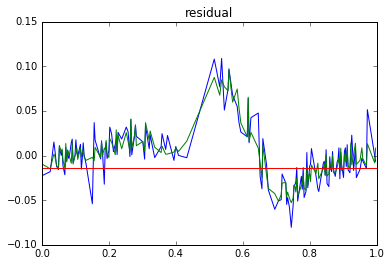

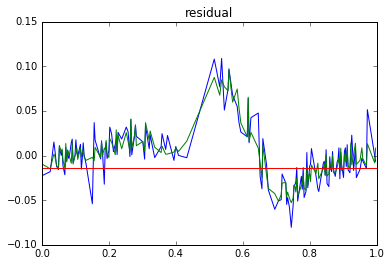

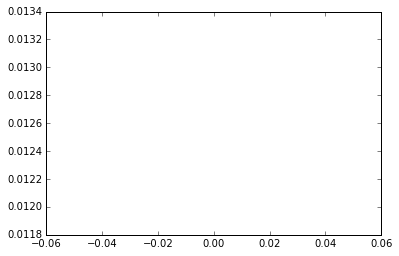

In [6]:
# get const A,b
# and re-weight kernels so they are same 'size'
# we should probably worry about -ves but lets not yet
# will put uncert in
# also consider PCT
K=np.array([I,R,L])
NN = 1

def cos(j,tt=tt,phi=None):
    # j int
    k = 500.
    if j == 0:
        return tt*0+1.
    if j < NN:
        ttt = np.array(tt - (j)/float(NN))
        ex = np.exp(-k*ttt)
        ret = ex/(1+ex)
        #ret = - k * ret*ret
        #print j,j_,ret.mean()
        if ret.mean():
            return ret  #/ret.mean()
        else:
            return ret
    return np.cos((j-NN) * np.pi*tt)

def cossin(j,tt=tt):
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return np.cos(j * np.pi*tt)
    else:
        return np.sin(j * np.pi*tt)

    
def cossin(j,tt=tt,phi=None):
    # so, a Fourier series
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return (np.cos(2*j * np.pi*tt))
    else:
        return (np.sin(2*j * np.pi*tt))

def cossinphase(j,tt=tt,phi=0.):
    # phase shifted DCT
    if j == 0:
        return tt*0+1
    else:
        return (np.cos(j * np.pi*tt + phi*np.pi/180.))

def cossinphase2(j,tt=tt,phi=0.):
    # phase shifted DCT
    
    if j == 0:
        return np.sin((j+1) * np.pi*tt + phi*np.pi/180.)
    else:
        return (np.cos((j) * np.pi*tt + phi*np.pi/180.))
    
fn = cos


comp = []
alphas = []
score = []
    
    
stepper = 0.6
xxx = 0

rmses = []
steppers = 0.2 + 0.6 * np.arange(40)/40.
steppers = [0]
for stepper in steppers:
    phi = 0
    # days since epoch
    t = data['system:time_start'][px,py][m] * 365 
    t -= t[0]

    start = 365*xxx # select a year of data
    ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
    t = t[ww] - start
    nbands = 7

    whichBands = [1]
    refl = np.array([data[i][px,py][m][ww] for i in whichBands])
    
    R = data['ross'][px,py][m][ww]
    L = data['li'][px,py][m][ww]
    I = data['isotropic'][px,py][m][ww]
    tt = t/365.25

    from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV,MultiTaskLassoCV,LassoLarsIC,ElasticNetCV
    import warnings
    warnings.warn('you are warned!')

    # sort info required
    K=np.array([I,R,L])
    
    refl = np.array([data[i][px,py][m][ww] for i in whichBands])

    # get intercept and weight kernels
    A,b,weights,KK = getAb(1,fn=fn,reweight=True,K=K,refl=refl,tt=tt,phi=0)
    K = (K.T/weights).T
    intercept = (A.I * b).T
    bshape = intercept/intercept[:,0]
    bshaper = K.T * bshape.T
    '''plt.figure()
    plt.title('mean')
    plt.plot(tt,np.array(refl).ravel()/np.array(bshaper).ravel())
    plt.plot(tt,refl.T,'+')'''
    fwd = np.dot(K.T,intercept.T).T
    residual = refl - fwd

    N = NN + 10

    lasso = LassoLarsIC(fit_intercept=False,criterion='bic')
    K_ = np.atleast_2d(K[0])
    K_ = K
    KK1 = np.array([(K_*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])
    KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))
    
    KK1[0][tt>stepper] = 0
    KK1[1][tt>stepper] = 0
    KK1[2][tt>stepper] = 0

    y = np.array(residual).flatten()
    lasso.fit(KK1.T,y)
    #plt.plot(tt,lasso.predict(KK1.T)+np.array(fwd).ravel(),'kx')
    plt.figure()
    plt.title('residual')
    plt.plot(tt,residual.T)
    plt.plot(tt,lasso.predict(KK1.T))
    
    summer = 0.
    for i in xrange(0,NN*3+1,3):
        summer += lasso.coef_[i] * KK1[i].T
    plt.plot(tt,summer)
    #plt.figure()
    difff = np.array(residual.T).ravel() - np.array(lasso.predict(KK1.T)).ravel()
    rmses.append(np.sqrt(np.mean(difff*difff)))
    #plt.title('residual residual')
    #plt.plot(tt,difff,'+')
    #plt.plot(tt,summer)
    
    sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)
    comp.append(sparseness)
    alphas.append(lasso.alpha_)
    score.append(lasso.score(KK1.T,y))
    

    
rmses = np.array(rmses)
steppers = np.array(steppers)

steper = steppers[np.argmin(rmses)]

lasso = LassoLarsIC(fit_intercept=False,criterion='bic')
K_ = np.atleast_2d(K[0])
K_ = K
KK1 = np.array([(K_*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])
KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))

KK1[0][tt>stepper] = 0
KK1[1][tt>stepper] = 0
KK1[2][tt>stepper] = 0

y = np.array(residual).flatten()
lasso.fit(KK1.T,y)
#plt.plot(tt,lasso.predict(KK1.T)+np.array(fwd).ravel(),'kx')
plt.figure()
plt.title('residual')
plt.plot(tt,residual.T)
plt.plot(tt,lasso.predict(KK1.T))

summer = 0.
for i in xrange(0,NN*3+1,3):
    summer += lasso.coef_[i] * KK1[i].T
plt.plot(tt,summer)
    
    
plt.figure()
plt.plot(steppers,rmses)


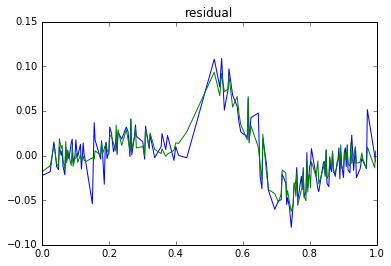

In [48]:



phi = 0
# days since epoch
t = data['system:time_start'][px,py][m] * 365 
t -= t[0]

start = 365*xxx # select a year of data
ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
t = t[ww] - start
nbands = 7

whichBands = [1]

R = data['ross'][px,py][m][ww]
L = data['li'][px,py][m][ww]
I = data['isotropic'][px,py][m][ww]
tt = t/365.25

# sort info required
K=np.array([I,R,L])

refl = np.array([data[i][px,py][m][ww] for i in whichBands])

# get intercept and weight kernels
A,b,weights,KK = getAb(10,fn=fn,reweight=True,K=K,refl=refl,tt=tt,phi=0)

#intercept = (A.I * b).T



bshape = intercept/intercept[:,0]
bshaper = K.T * bshape.T
fwd = np.dot(K.T,intercept.T).T
residual = refl - fwd



N = 10

lasso = LassoLarsIC(fit_intercept=False,criterion='bic')
K_ = np.atleast_2d(K[0])
K_ = K
KK1 = np.array([(K_*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])
KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))

KK1[0][tt>stepper] = 0
KK1[1][tt>stepper] = 0
KK1[2][tt>stepper] = 0

y = np.array(residual).flatten()
lasso.fit(KK1.T,y)
#plt.plot(tt,lasso.predict(KK1.T)+np.array(fwd).ravel(),'kx')
plt.figure()
plt.title('residual')
plt.plot(tt,residual.T)
plt.plot(tt,lasso.predict(KK1.T))


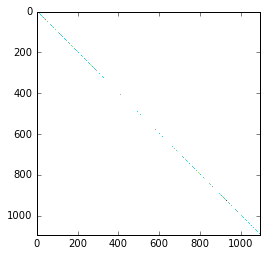

In [673]:
#[plt.plot(tt,fn(N,phi=phi,tt=tt)) for N in [1]]
from scipy.linalg import solve

def get_D2(nT):
    from scipy.sparse import coo_matrix, bmat
    I = np.identity(nT)
    D = I - np.roll(I,-1)
    D21 = np.dot(D.T,D)[::-1,::-1]
    D2 = np.dot(D,D.T)

    D2_ = coo_matrix(D2)
    col,row,d2 =  D2_.col,D2_.row,D2_.data

    col_ = np.vstack([col*3,col*3+1,col*3+2]).T.flatten()
    row_ = np.vstack([row*3,row*3+1,row*3+2]).T.flatten()
    d2_  = np.vstack([d2,d2,d2]).T.flatten()
    D2_ = coo_matrix((d2_,(row_,col_)),shape=(nT*3,nT*3))
    return D2_

def get_KTK(nT,KK,refl,ti):
    from scipy.sparse import coo_matrix, bmat
    nt = ti.shape[0]

    # form sparse locations on grid from time info
    new_col = np.array([ti*3,ti*3+1,ti*3+2]).T.flatten()
    col = np.repeat(new_col,3,axis=0)
    new_row = np.array([ti*3,ti*3,ti*3]).T.flatten()
    row = np.repeat(new_row,3,axis=0) + np.tile(np.arange(0,3),nt*3)
    KTK = np.einsum('kl,tl -> ktl',KK,KK)
    B   = np.einsum('kl,s -> ks',KK,refl[0])

    KTK_ = coo_matrix((KTK.T.flatten(),(row,col)),shape=(nT*3,nT*3))
    B_   = coo_matrix((B.T.flatten(),(0*new_col,new_col)),shape=(1,nT*3))
    return KTK_,B_

def get_D2(nT):
    # [p0,p1,p2]
    from scipy.sparse import coo_matrix, bmat
    I = np.identity(nT)
    D = I - np.roll(I,-1)
    D21 = np.dot(D.T,D)[::-1,::-1]
    D2 = np.dot(D,D.T)
    D2_ = bmat([[D2,None,None],[None,D2,None],[None,None,D2]])
    return D2_

def get_KTK(nT,KK,refl,ti):
    # project weighted K and observations
    from scipy.sparse import coo_matrix, bmat
    nt = ti.shape[0]

    # form sparse locations on grid from time info
    new_col = np.array([ti*3,ti*3+1,ti*3+2]).T.flatten()
    col = np.repeat(new_col,3,axis=0)
    new_row = np.array([ti*3,ti*3,ti*3]).T.flatten()
    row = np.repeat(new_row,3,axis=0) + np.tile(np.arange(0,3),nt*3)
    KTK = np.einsum('kl,tl -> ktl',KK,KK)
    B   = np.einsum('kl,s -> ks',KK,refl[0])

    KTK_ = coo_matrix((KTK.T.flatten(),(row,col)),shape=(nT*3,nT*3))
    B_   = coo_matrix((B.T.flatten(),(0*new_col,new_col)),shape=(1,nT*3))
    return KTK_,B_


from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

def cos(j,tt=tt,phi=None):
    # j int
    return np.cos((j) * np.pi*tt)
fn = cos

phi = 0
# days since epoch
t = data['system:time_start'][px,py][m] * 365 
t -= t[0]

start = 365*1 # select a year of data
ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
t = t[ww] - start
nbands = 7

whichBands = [1]

R = data['ross'][px,py][m][ww]
L = data['li'][px,py][m][ww]
I = data['isotropic'][px,py][m][ww]
tt = t/365.25
nt = len(tt)
nT = 365
# sort info required
K=np.array([I,R,L])

refl = np.array([data[i][px,py][m][ww] for i in whichBands])
N = 9
# get intercept and weight kernels
#A,b,KK = getAb(1,fn=fn,reweight=True,K=K,refl=refl,tt=tt,phi=0)
## KK here are re-weighted kernels
#KK = KK[0]


# sample time
ttt = np.arange(nT)

D2 = get_D2(nT)
KTK,B = get_KTK(nT,KK,refl,ti)
gamma = 100.


f = np.matrix((KTK).toarray())
f[f==0] = np.nan
plt.imshow(f)

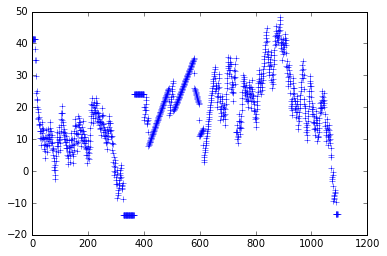

In [661]:
plt.plot(spsolve(KTK+gamma*D2,B.T),'+')

In [659]:
from scipy.sparse import coo_matrix, bmat
nt = ti.shape[0]
KTK = np.einsum('kl,tl -> ktl',KK,KK)
B   = np.einsum('kl,s -> ks',KK,refl[0])

KTK_ = [[None]*nT]*nT
B_   = [None]*nT

for i in xrange(nT):
    KTK_[i][i] = np.eye(3)
    
for i in xrange(nt):
    KTK_[ti[i]][ti[i]] = KTK_[ti[i]][ti[i]] + KTK[:,:,i]
    B_[ti[i]] = B[:,i]
    
print nt
print (KTK_[162][164])
#r = bmat(KTK_)


163
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


In [ ]:
#[plt.plot(tt,fn(N,phi=phi,tt=tt)) for N in [1]]
from scipy.linalg import solve

def cos(j,tt=tt,phi=None):
    # j int
    return np.cos((j) * np.pi*tt)
fn = cos

phi = 0
# days since epoch
t = data['system:time_start'][px,py][m] * 365 
t -= t[0]

start = 365*1 # select a year of data
ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
t = t[ww] - start
nbands = 7

whichBands = [2]

R = data['ross'][px,py][m][ww]
L = data['li'][px,py][m][ww]
I = data['isotropic'][px,py][m][ww]
tt = t/365.25

# sort info required
K=np.array([I,R,L])

refl = np.array([data[i][px,py][m][ww] for i in whichBands])
N = 9
# get intercept and weight kernels
A,b,KK = getAb(N,fn=fn,reweight=True,K=K,refl=refl,tt=tt,phi=0)
A = np.array(A)
b = np.array(b)
x = solve(A,b)
KK = KK.reshape((N*3,refl.shape[-1]))
fwd = np.dot(KK.T,x)
plt.plot(tt,fwd,'r+')
plt.plot(tt,refl.T,'kx')
#fwd = 
ttt = np.arange(100)/100.
KKK=np.array([np.ones_like(ttt),np.zeros_like(ttt),np.zeros_like(ttt)])
AA,bb,KK = getAb(N,fn=fn,reweight=False,K=KKK,refl=None,tt=ttt,phi=0)
KK = KK.reshape((N*3,KK.shape[-1]))
plt.plot(ttt,np.dot(KK.T,x))

[ 0.08129409] [ 0.02142862]


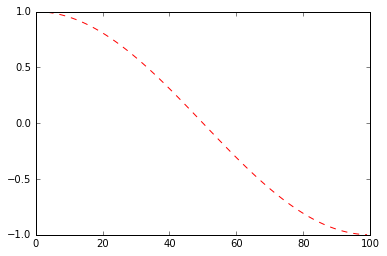

In [233]:
x = solve(A,b)
plt.plot(KK[0],'k-')
plt.plot(KK[3],'r--')
print x[0],x[3]

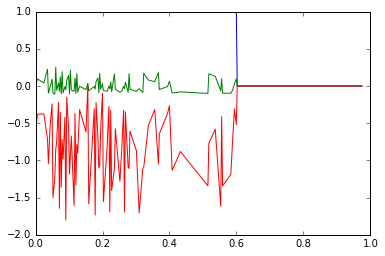

In [438]:


KK1[0][tt>0.6] = 0
KK1[1][tt>0.6] = 0
KK1[2][tt>0.6] = 0

plt.plot(tt,KK1[0])
plt.plot(tt,KK1[1])
plt.plot(tt,KK1[2])



/Users/plewis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: UserWarning: you are warned!
/Users/plewis/anaconda/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 86 iterations, alpha=6.050e-05, previous alpha=9.150e-06, with an active set of 61 regressors.
  ConvergenceWarning)


0
[ 60.]


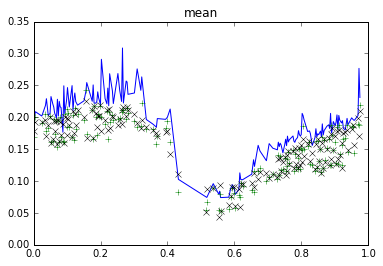

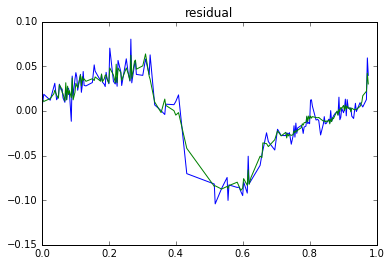

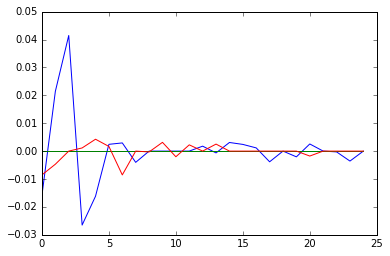

In [404]:
# get const A,b
# and re-weight kernels so they are same 'size'
# we should probably worry about -ves but lets not yet
# will put uncert in
# also consider PCT
K=np.array([I,R,L])
NN = 10

def cos(j,tt=tt,phi=None):
    return np.cos((j) * np.pi*tt)

def cossin(j,tt=tt):
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return np.cos(j * np.pi*tt)
    else:
        return np.sin(j * np.pi*tt)

    
def cossin(j,tt=tt,phi=None):
    # so, a Fourier series
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return (np.cos(2*j * np.pi*tt))
    else:
        return (np.sin(2*j * np.pi*tt))

def cossinphase(j,tt=tt,phi=0.):
    # phase shifted DCT
    if j == 0:
        return tt*0+1
    else:
        return (np.cos(j * np.pi*tt + phi*np.pi/180.))

def cossinphase2(j,tt=tt,phi=0.):
    # phase shifted DCT
    
    if j == 0:
        return np.sin((j+1) * np.pi*tt + phi*np.pi/180.)
    else:
        return (np.cos((j) * np.pi*tt + phi*np.pi/180.))
    
fn = cos


comp = []
alphas = []
score = []
    
for xxx in [0]:
    phi = 0
    print phi
    # days since epoch
    t = data['system:time_start'][px,py][m] * 365 
    t -= t[0]

    start = 365*xxx # select a year of data
    ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
    t = t[ww] - start
    nbands = 7

    whichBands = [0]
    refl = np.array([data[i][px,py][m][ww] for i in whichBands])
    
    R = data['ross'][px,py][m][ww]
    L = data['li'][px,py][m][ww]
    I = data['isotropic'][px,py][m][ww]
    tt = t/365.25

    from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV,MultiTaskLassoCV,LassoLarsIC
    import warnings
    warnings.warn('you are warned!')

    # sort info required
    K=np.array([I,R,L])
    
    refl = np.array([data[i][px,py][m][ww] for i in whichBands])

    # get intercept and weight kernels
    A,b,weights,KK = getAb(1,fn=fn,reweight=True,K=K,refl=refl,tt=tt,phi=0)
    K = (K.T/weights).T
    intercept = (A.I * b).T
    bshape = intercept/intercept[:,0]
    bshaper = K.T * bshape.T
    plt.figure()
    plt.title('mean')
    plt.plot(tt,np.array(refl).ravel()/np.array(bshaper).ravel())
    plt.plot(tt,refl.T,'+')
    fwd = np.dot(K.T,intercept.T).T
    residual = refl - fwd

    N = NN + 15

    lasso = LassoLarsIC(fit_intercept=False,criterion='bic')
    KK1 = np.array([(K*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])
    KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))
    y = np.array(residual).flatten()
    lasso.fit(KK1.T,y)
    plt.plot(tt,lasso.predict(KK1.T)+np.array(fwd).ravel(),'kx')
    plt.figure()
    plt.title('residual')
    plt.plot(tt,residual.T)
    plt.plot(tt,lasso.predict(KK1.T))
    sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)
    comp.append(sparseness)
    alphas.append(lasso.alpha_)
    score.append(lasso.score(KK1.T,y))
plt.figure()
print np.array(comp)*100
plt.plot(lasso.coef_[::3])
plt.plot(lasso.coef_[1::3])
plt.plot(lasso.coef_[2::3])


#print lasso.coef_

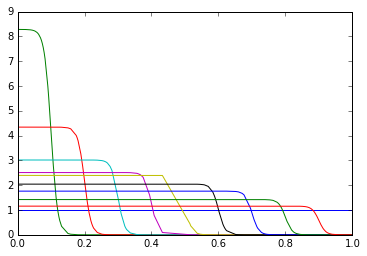

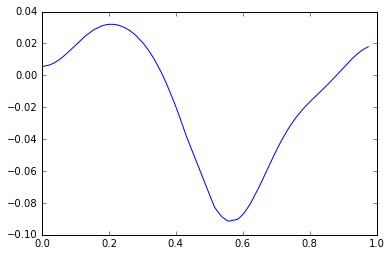

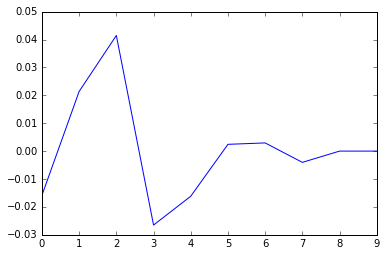

In [405]:
plt.figure()
ff = np.array([KK1[i*3,:].T * lasso.coef_[i*3] for i in xrange(NN+1)]).sum(axis=0)
plt.plot(tt,ff)

plt.figure()
plt.plot(lasso.coef_[::3][:NN])

In [211]:
print lasso.coef_[::3][:NN],np.argmax(lasso.coef_[::3][:NN])/float(NN)

[ 0.          0.          0.00083617  0.          0.          0.          0.
  0.          0.          0.        ] 0.2


0
[[ 1.26350314]] [[ 0.02726252]]
[ 62.22222222]
-154.204847625 degrees


/Users/plewis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:74: UserWarning: you are warned!


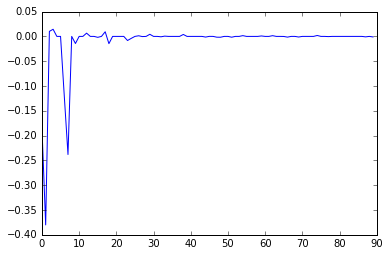

In [169]:
# get const A,b
# and re-weight kernels so they are same 'size'
# we should probably worry about -ves but lets not yet
# will put uncert in
# also consider PCT
K=np.array([I,R,L])

def cos(j,tt=tt):
    # j int
    return np.cos(j * np.pi*tt)

def cossin(j,tt=tt):
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return np.cos(j * np.pi*tt)
    else:
        return np.sin(j * np.pi*tt)

    
def cossin(j,tt=tt,phi=None):
    # so, a Fourier series
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return (np.cos(2*j * np.pi*tt))
    else:
        return (np.sin(2*j * np.pi*tt))

def cossinphase(j,tt=tt,phi=0.):
    # phase shifted DCT
    if j == 0:
        return tt*0+1
    else:
        return (np.cos(j * np.pi*tt + phi*np.pi/180.))

def cossinphase2(j,tt=tt,phi=0.):
    # phase shifted DCT
    
    if j == 0:
        return np.sin((j+1) * np.pi*tt + phi*np.pi/180.)
    else:
        return (np.cos((j) * np.pi*tt + phi*np.pi/180.))
    
fn = cossinphase2


comp = []
alphas = []
score = []
    
for xxx in [0]:
    phi = 0
    print phi
    # days since epoch
    t = data['system:time_start'][px,py][m] * 365 
    t -= t[0]

    start = 365*xxx # select a year of data
    ww = np.logical_and(t <= t[0]+ start + 365,t >= start)
    t = t[ww] - start
    nbands = 7

    whichBands = [1]
    refl = np.array([data[i][px,py][m][ww] for i in whichBands])
    
    R = data['ross'][px,py][m][ww]
    L = data['li'][px,py][m][ww]
    I = data['isotropic'][px,py][m][ww]
    tt = t/365.25

    from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV,MultiTaskLassoCV,LassoLarsIC
    import warnings
    warnings.warn('you are warned!')

    # sort info required
    K=np.array([I,R,L])
    
    refl = np.array([data[i][px,py][m][ww] for i in whichBands])

    # get intercept and weight kernels
    A,b,weights,KK = getAb(1,fn=fn,reweight=True,K=K,refl=refl,tt=tt,phi=0)
    K = (K.T/weights).T
    intercept = (A.I * b).T
    Rs,Ls = intercept[:,1]/intercept[:,0],intercept[:,2]/intercept[:,0]
    print Rs,Ls
    fwd = np.dot(K.T,intercept.T).T
    residual = refl - fwd

    N = 30

    lasso = LassoLarsIC(fit_intercept=False,criterion='bic')
    KK1 = np.array([(K*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])
    KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))
    y = np.array(residual).flatten()
    lasso.fit(KK1.T,y)
    sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)
    comp.append(sparseness)
    alphas.append(lasso.alpha_)
    score.append(lasso.score(KK1.T,y))

print np.array(comp)*100
plt.plot(lasso.coef_)
#print lasso.coef_
print np.arctan2(lasso.coef_[0],lasso.coef_[1])*180./np.pi,'degrees'

# Model is:

$$
\rho = V_0 k x_0 + V_1 k x_1 + ... + V_{n-1} k x_{n-1} + \epsilon
$$

with $V_i = 2 cos(\omega_i t)$ and $\omega_i = k \pi$ and

$$
k = \left( 1, k_1,  k_2, \right)
$$

which is a function of time $t$ (i.e. of the temporal and angular sampling) since $k_i$ are angular kernels.

from which

$$
J = \frac{1}{2} \epsilon^2 =  \frac{1}{2} \left( \rho - \right)
$$

In [144]:
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV,MultiTaskLassoCV,LassoLarsIC
import warnings
warnings.warn('you are warned!')

# sort info required
K=np.array([I,R,L])
refl = np.array([data[i][px,py][m][ww] for i in whichBands])


# get intercept and weight kernels
A,b,weights,KK = getAb(1,fn=fn,tt=tt,phi=0,reweight=True,K=K,refl=refl)
K = (K.T/weights).T
intercept = (A.I * b).T
fwd = np.dot(K.T,intercept.T).T
residual = refl - fwd

N = 40
def cossin(j,tt=tt,phi=None):
    # so, a Fourier series
    if j == 0:
        return tt*0+1
    elif j%2 == 0:
        return (np.cos(2*j * np.pi*tt))
    else:
        return (np.sin(2*j * np.pi*tt))
fn = cossin

def cossinphase(j,tt=tt,phi=45):
    # phase shifted DCT
    if j == 0:
        return tt*0+1
    else:
        return (np.cos(j * np.pi*tt + phi*np.pi/180.))
    
def cossinphase2(j,tt=tt,phi=0.,p=1):
    # phase shifted DCT
    
    if j == 0:
        return tt*0+1.
    else:
        return (np.cos((j) * np.pi*tt + phi*np.pi/180.)**p)
    
def xxcossinphase2(j,tt=tt,phi=0.,p=1):
    # phase shifted DCT
    
    if j == 0:
        return tt*0+1.
    elif j%2 == 1:
        return np.array(np.cos((j/2+1) * np.pi*tt + phi*np.pi/180.)**p)
    else:
        return np.array(np.sin((j/2) * np.pi*tt + phi*np.pi/180.)**p)
    
fn = cossinphase2

lasso = LassoLarsIC(fit_intercept=False,criterion='bic')

phis = []
comp = []
alphas = []
score = []

'''plt.figure()
for phi in np.arange(0,180,1.):
    phis.append(phi)
    KK1 = np.array([(K*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])
    KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))
    y = np.array(residual).flatten()
    try:
        lasso.fit(KK1.T,y)
    except:
        pass
    sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)
    comp.append(sparseness)
    alphas.append(lasso.alpha_)
    score.append(lasso.score(KK1.T,y))
plt.plot(phis,comp - np.array(score))
'''



/Users/plewis/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: you are warned!
  app.launch_new_instance()


'plt.figure()\nfor phi in np.arange(0,180,1.):\n    phis.append(phi)\n    KK1 = np.array([(K*(fn(j,phi=phi,tt=tt))) for j in xrange(N)])\n    KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))\n    y = np.array(residual).flatten()\n    try:\n        lasso.fit(KK1.T,y)\n    except:\n        pass\n    sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)\n    comp.append(sparseness)\n    alphas.append(lasso.alpha_)\n    score.append(lasso.score(KK1.T,y))\nplt.plot(phis,comp - np.array(score))\n'

21
Solution is %82.5 sparse


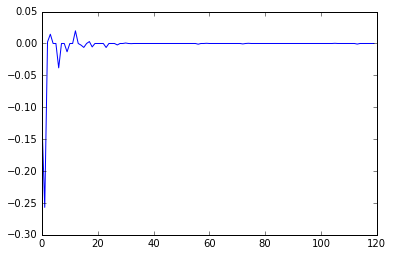

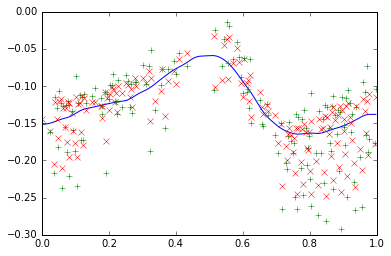

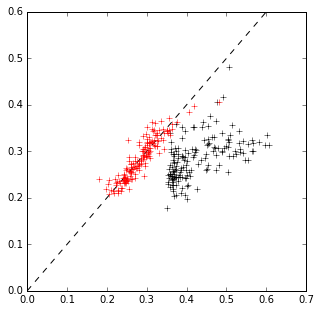

In [149]:

phi = 0.
lasso = LassoLarsIC(fit_intercept=False,criterion='bic',normalize=True,copy_X=True)
#lasso = Lasso(fit_intercept=False,normalize=True,copy_X=True,alpha=0.00224120843149)

fn = cossinphase2
p = 1

KK1 = np.array([(K*(fn(j,phi=phi,tt=tt,p=p))) for j in xrange(N)])
KK1 = KK1.reshape((np.prod(KK1.shape[:2]),KK1.shape[2]))
y = np.array(residual).flatten()
lasso.fit(KK1.T,y)


plt.plot(lasso.coef_.T)
sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)
print np.sum(lasso.coef_ != 0)
print "Solution is %{0} sparse".format(100.*sparseness)

nk = 3
t = np.arange(365)/365.
I0 = np.ones_like(t)
R0 = np.zeros_like(t)

K0tt = np.array([(np.array([I,R,L])*(fn(j,tt=tt,phi=phi))) for j in xrange(N)]).reshape((3*N,len(tt)))
K0 = np.array([np.array([I0,R0,R0])*(fn(j,tt=t,phi=phi)) for j in xrange(N)]).reshape((3*N,len(t)))
plt.figure()

plt.plot(t,lasso.predict(K0.T))
plt.plot(tt,residual.T,'+')
plt.plot(tt,lasso.predict(K0tt.T).T,'x')


plt.figure(figsize=(5,5))
plt.plot(fwd.T,refl.T,'k+')
plt.plot([0,0.6],[0,0.6],'k--')
plt.plot((refl).T,(lasso.predict(K0tt.T).T + fwd.flatten()).T,'r+')

0.00224120843149
21
Solution is %82.5 sparse
[ 1.  1.  1.]


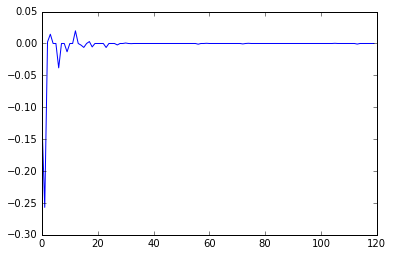

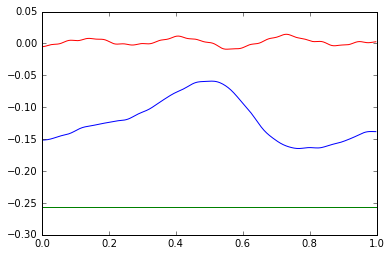

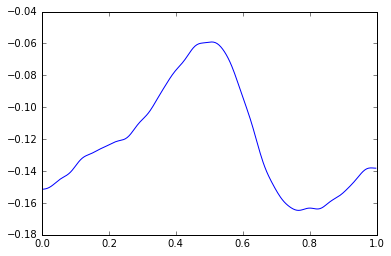

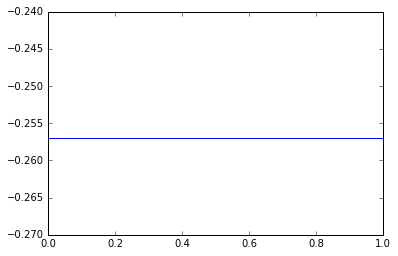

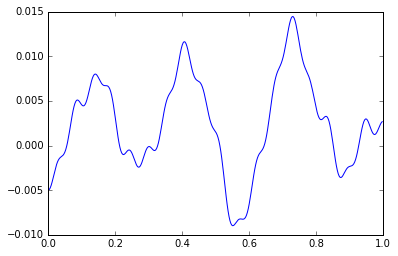

In [150]:
print 0.00224120843149
plt.plot((lasso.coef_).T)
sparseness = np.sum(lasso.coef_ == 0)/float(lasso.coef_.size)
print np.sum(lasso.coef_ != 0)
print "Solution is %{0} sparse".format(100.*sparseness)

t = np.arange(365)/365.
I0 = np.ones_like(t)
R0 = np.zeros_like(t)
plt.figure()
K0 = np.array([(np.array([I0,R0,R0])*(fn(j,tt=t,phi=phi))) for j in xrange(N)]).reshape((3*N,len(t))).T
plt.plot(t,lasso.predict(K0)*weights[0])
K1 = np.array([(np.array([R0,I0,R0])*(fn(j,tt=t,phi=phi))) for j in xrange(N)]).reshape((3*N,len(t))).T
plt.plot(t,lasso.predict(K1)*weights[1])
K2 = np.array([(np.array([R0,R0,I0])*(fn(j,tt=t,phi=phi))) for j in xrange(N)]).reshape((3*N,len(t))).T
plt.plot(t,lasso.predict(K2)*weights[2])


plt.figure()

plt.plot(t,lasso.predict(K0)*weights[0])
plt.figure()
plt.plot(t,lasso.predict(K1)*weights[1])
plt.figure()
plt.plot(t,lasso.predict(K2)*weights[2])
print weights

In [52]:
help(LassoLarsCV)

Help on class LassoLarsCV in module sklearn.linear_model.least_angle:

class LassoLarsCV(LarsCV)
 |  Cross-validated Lasso, using the LARS algorithm
 |  
 |  The optimization objective for Lasso is::
 |  
 |  (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
 |  
 |  Read more in the :ref:`User Guide <least_angle_regression>`.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : boolean
 |      whether to calculate the intercept for this model. If set
 |      to false, no intercept will be used in calculations
 |      (e.g. data is expected to be already centered).
 |  
 |  positive : boolean (default=False)
 |      Restrict coefficients to be >= 0. Be aware that you might want to
 |      remove fit_intercept which is set True by default.
 |      Under the positive restriction the model coefficients do not converge
 |      to the ordinary-least-squares solution for small values of alpha.
 |      Only coeffiencts up to the smallest alpha value (``alphas_[alphas_ >
 |      0.].m